In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# scanpy is used for single cell analysis

In [18]:
# Modify this as needed! I upload the zip file first then upzip it on sockeye. 
adata = sc.read_h5ad("/arc/project/st-jimsun-1/axu03/vcc_data/adata_Training.h5ad")

AnnData object with n_obs × n_vars = 221273 × 18080
    obs: 'target_gene', 'guide_id', 'batch'
    var: 'gene_id'


In [1]:
# check training data 
print(adata)
print(adata.shape)  # (n_cells, n_genes)
print(adata.obs.head())
print(adata.var.head())

NameError: name 'adata' is not defined

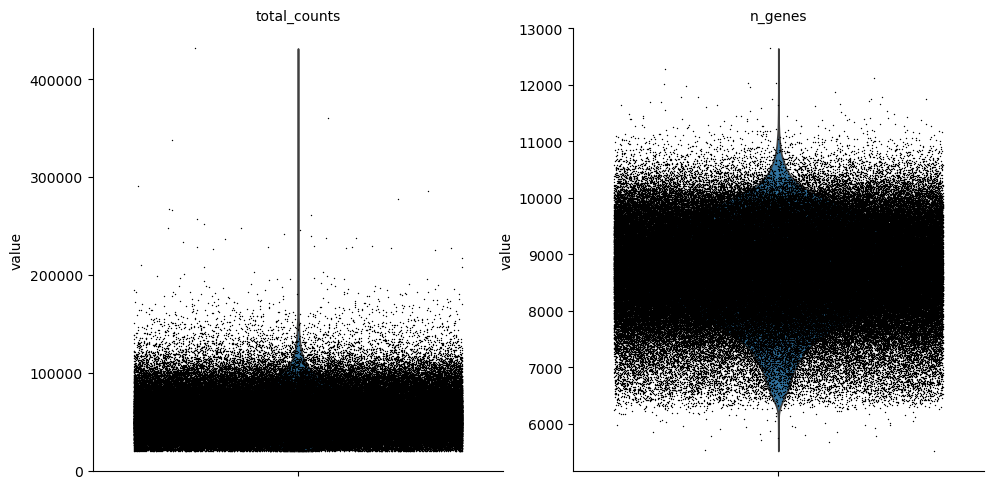

In [27]:
if hasattr(adata.X, "toarray"):  # sparse matrix
    adata.obs['total_counts'] = np.array(adata.X.sum(axis=1)).flatten()
else:
    adata.obs['total_counts'] = adata.X.sum(axis=1)
# Number of nonzero genes per guide
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1 if hasattr(adata.X, "A1") else (adata.X > 0).sum(axis=1)
# Make a violin plot
sc.pl.violin(adata, ['total_counts', 'n_genes'], jitter=0.4, multi_panel=True)

ACTB      93888584.0
CD24      54895904.0
POU5F1    38948344.0
EEF2      33064416.0
HSPA8     31512622.0
TMSB4X    29862872.0
OAZ1      29423284.0
ACTG1     29189972.0
TUBB2B    26842304.0
LDHB      25063512.0
dtype: float32


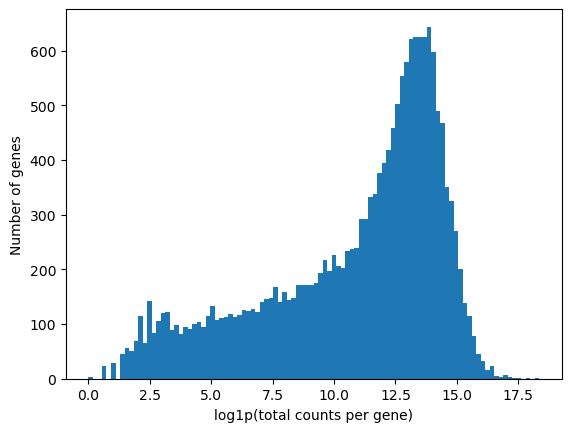

In [30]:
gene_counts = np.array(adata.X.sum(axis=0)).flatten() if hasattr(adata.X, "toarray") else adata.X.sum(axis=0).A1
gene_counts_series = pd.Series(gene_counts, index=adata.var_names)

# CHeck top expressed genes
print(gene_counts_series.sort_values(ascending=False).head(10))
# Plot histogram of log transformed gene counts to check distribution
plt.hist(np.log1p(gene_counts_series), bins=100)
plt.xlabel('log1p(total counts per gene)')
plt.ylabel('Number of genes')
plt.show()

In [2]:
sc.pp.normalize_total(adata, target_sum=1e4)  # CPM-like normalization
sc.pp.log1p(adata)

# Make categorical
adata.obs['batch'] = adata.obs['batch'].astype('category')
adata.obs['target_gene'] = adata.obs['target_gene'].astype('category')

sc.settings.figdir = './figures'
os.makedirs(sc.settings.figdir, exist_ok=True)

# Angela: I'm not too sure how to color the PCA/UMAP since there are 200 different interferences. 
# I'm still thinking about how to explore and potentially remove batch effects. 

# PCA plot of top 2000 most variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat')
adata_pca = adata[:, adata.var['highly_variable']] if 'highly_variable' in adata.var else adata
sc.tl.pca(adata_pca, svd_solver='arpack')
sc.pl.pca(adata_pca, color='batch', save='_pca_batch.png')
# Save PCA plot colored by target_gene as a PNG
sc.pl.pca(adata_pca, color='target_gene', save='_pca_target.png')

NameError: name 'sc' is not defined

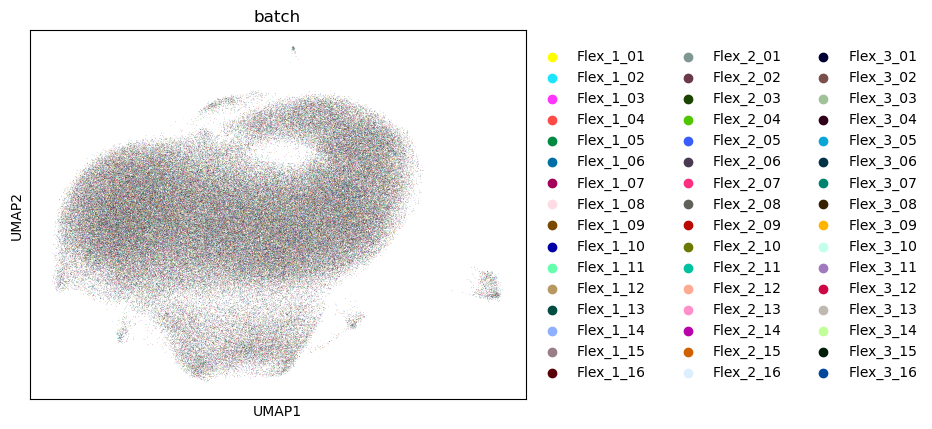

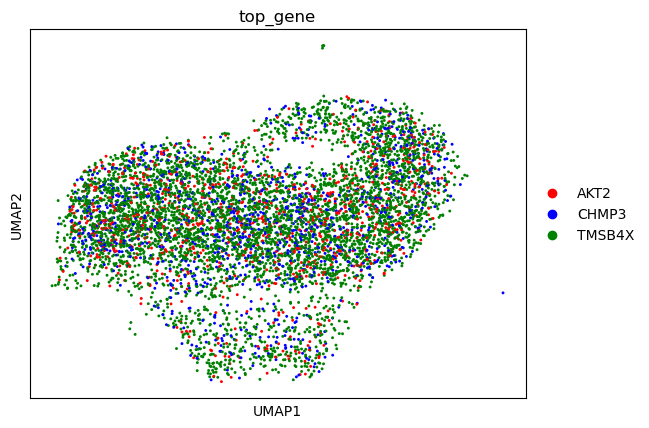

In [41]:
# Compute neighbors & UMAP
sc.pp.neighbors(adata_pca, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata_pca)
# UMAP colored by batch
sc.pl.umap(
    adata_pca,
    color='batch',
    save='_umap_batch.png',
    show=True
)

# UMAP colored by a small subset of target genes, just to check if they separate (no they don't!)
top_genes = ['CHMP3', 'AKT2', 'TMSB4X']
adata_subset = adata_pca[adata_pca.obs['target_gene'].isin(top_genes)].copy()
adata_subset.obs['top_gene'] = adata_subset.obs['target_gene']
adata_subset.obs['top_gene'] = adata_subset.obs['top_gene'].astype('category')
sc.pl.umap(
    adata_subset,
    color='top_gene',        # use the new column
    palette=['red','blue','green'],  # optional: assign colors manually
    save='_umap_topgenes.png',
    show=True
)